In [2]:
!pip install einops

#### Imports & Configurations
- unzip zipped files


In [1]:
import os, shutil, gc, zipfile
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import natsort
import numpy as np
import cv2
import random
from PIL import Image
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch import Tensor
from torchsummary import summary
from torch.optim import lr_scheduler

# Sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold

# einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce



#### Faster RCNN

#### Data처리및 Explore
- unzip train, test folders
- json, csv, jpg파일 폴더별로 분리

In [ ]:
train_zip = zipfile.ZipFile('/content/drive/MyDrive/dacon/LGfarm/data/train.zip')
test_zip = zipfile.ZipFile('/content/drive/MyDrive/dacon/LGfarm/data/test.zip')

train_zip.extractall('/content/drive/MyDrive/dacon/LGfarm/data/train')
test_zip.extractall('/content/drive/MyDrive/dacon/LGfarm/data')

In [ ]:
shutil.move('/content/drive/MyDrive/dacon/LGfarm/data/TEST/test', '/content/drive/MyDrive/dacon/LGfarm/data')

'/content/drive/MyDrive/dacon/LGfarm/data/test'

In [ ]:
shutil.move('/content/drive/MyDrive/dacon/LGfarm/data/TRAIN/train', '/content/drive/MyDrive/dacon/LGfarm/data/train')

'/content/drive/MyDrive/dacon/LGfarm/data/train'

In [2]:
def create_folder(dir):
  try:
    if not os.path.exists(dir):
      os.makedirs(dir)
  except OSError:
    print(f'Error in creating Directory for {dir}')

def delete_folder(dir):
  try:
    if os.path.exists(dir):
      os.rmdir(dir)
  except OSError:
    print(f"Unable to Remove Directory {dir}")

In [ ]:
len(os.listdir('/content/drive/MyDrive/dacon/LGfarm/data/train/CSV'))

5767

In [3]:
DATA_DIR = '/content/drive/MyDrive/dacon/LGfarm/data'
TRAIN_DIR = '/content/drive/MyDrive/dacon/LGfarm/data/train'
TEST_DIR = '/content/drive/MyDrive/dacon/LGfarm/data/test'

TRAIN_ID_LIST = natsort.natsorted(os.listdir(TRAIN_DIR), reverse = False)

TEST_ID_LIST = natsort.natsorted(os.listdir(TEST_DIR), reverse = False)

create_folder(os.path.join(TRAIN_DIR, 'CSV'))
create_folder(os.path.join(TRAIN_DIR, 'JSON'))
create_folder(os.path.join(TRAIN_DIR, 'JPG'))

TRAIN_CSV_DIR = os.path.join(TRAIN_DIR, 'CSV')
TRAIN_JSON_DIR = os.path.join(TRAIN_DIR, 'JSON')
TRAIN_JPG_DIR = os.path.join(TRAIN_DIR, 'JPG')

def move_files(id_list, mode = 'train'):
  if mode == 'train':
    dir = TRAIN_DIR
  else:dir = TEST_DIR

  for i, id in enumerate(id_list):
    base = os.path.join(dir, id)
    csv_dir = os.path.join(base, id + '.csv')
    json_dir = os.path.join(base, id + '.json')
    jpg_dir = os.path.join(base, id + '.jpg')
    if os.path.isfile(csv_dir):
      if mode == 'train':
        shutil.move(csv_dir, os.path.join(TRAIN_CSV_DIR, os.path.basename(csv_dir)))
      else:
        shutil.move(csv_dir, os.path.join(TEST_CSV_DIR, os.path.basename(csv_dir)))
    if os.path.isfile(json_dir):
      if mode == 'train':
        shutil.move(json_dir, os.path.join(TRAIN_JSON_DIR, os.path.basename(json_dir)))
      else:
        shutil.move(json_dir, os.path.join(TEST_JSON_DIR, os.path.basename(json_dir)))
    if os.path.isfile(jpg_dir):
      if mode == 'train':
        shutil.move(jpg_dir, os.path.join(TRAIN_JPG_DIR, os.path.basename(jpg_dir)))
      else:
        shutil.move(jpg_dir, os.path.join(TEST_JPG_DIR, os.path.basename(jpg_dir)))


In [4]:
def read_json(dir):
  with open(dir, 'r') as f:
    json_data = json.load(f)
  return json_data

TRAIN_ID_LIST = list(map(lambda x: x.split('.')[0], os.listdir('/content/drive/MyDrive/dacon/LGfarm/data/train/CSV')))

In [5]:
TRAIN_CSV_FILES = natsort.natsorted(glob(os.path.join(TRAIN_CSV_DIR, '*.csv')))
TRAIN_JSON_FILES = natsort.natsorted(glob(os.path.join(TRAIN_JSON_DIR, '*.json')))
TRAIN_JPG_FILES = natsort.natsorted(glob(os.path.join(TRAIN_JPG_DIR, '*.jpg')))
print(f'{len(TRAIN_CSV_FILES)} {len(TRAIN_JSON_FILES)} {len(TRAIN_JPG_FILES)}')

5767 5767 5767


In [6]:
# 모든 이미지들의 높이, 너비, task, 그리고 region에 대해 알아보자
desc_info, annot_info = pd.DataFrame(), pd.DataFrame()

for i, json_dir in enumerate(TRAIN_JSON_FILES):
  data = read_json(json_dir)
  description, annotations = data['description'], data['annotations']
  for key in annotations.keys():
    data = annotations[key]
    if isinstance(data, list):
      annotations[key] = [data]
  desc_info = pd.concat([desc_info, pd.DataFrame(description, index = [TRAIN_ID_LIST[i]])], axis = 0)
  annot_info = pd.concat([annot_info, pd.DataFrame(annotations, index = [TRAIN_ID_LIST[i]])], axis = 0)

In [7]:
# {작물 코드}_{작물 상태 코드}_{질병 피해 정도} 형태의 문자열로 라벨링하는 것이 목적이다.
def get_all_labels(annot_df):
  labels = []
  indexes = annot_info.index
  for i, idx in enumerate(indexes):
    annot = annot_info.loc[idx]
    crop, disease, risk = annot['crop'], annot['disease'], annot['risk']
    label = f"{crop}_{disease}_{risk}"
    labels.append(label)
  
  return list(set(labels))

labels = get_all_labels(annot_info)
print(len(labels))

25


- 제일 많은 종류의 길이는 294인데 이경우에는 비어있는 데이터를 어떻게 채워줄지가 제일 큰 고민이다.
- 데이터별 시간의 흐름에 따른 데이터 정보의 추이를 파악해 보아야 할 것이다.


In [8]:
import cv2, math
import numpy as np
TRAIN_IMAGE_NAMES = list(desc_info['image'])

def get_img_by_id(img_id):
  IMG_BASE = '/content/drive/MyDrive/dacon/LGfarm/data/train/JPG'
  img_dir = os.path.join(IMG_BASE, img_id)
  
  img = cv2.imread(img_dir)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def crop_img_by_id(img_id, annot_df):
  img = get_img_by_id(img_id)
  id = img_id.split('.')[0]
  id = TRAIN_IMAGE_NAMES.index(img_id)
  bbox = annot_info['bbox'][id][0]
  img_id = desc_info['image'][id]
  x1, y1 = bbox['x'], bbox['y']
  x2, y2 = x1 + bbox['w'], y1 + bbox['h']
  x1, y1 = math.floor(x1), math.floor(y1)
  x2, y2 = math.ceil(x2), math.ceil(y2)
  #x1,x2,y1,y2 = np.float32(x1), np.float32(x2), np.float32(y1), np.float32(y2)
  img = img[y1:y2, x1:x2]

  return img

def plot_bbox_on_img(id, annot_df, desc_df):
  # 주목 객체 바운딩 박스를 cv2를 사용해서 이미지에 나타냄
  img_id = id + '.jpg'
  id = TRAIN_IMAGE_NAMES.index(img_id)
  bbox = annot_info['bbox'][id][0]
  img_id = desc_info['image'][id]
  # gets parameters of the id of the image and the dataframe used to get the information of the annotations
  width, height = desc_df['width'][id], desc_info['height'][id]
  x1, y1 = bbox['x'], bbox['y']
  x2, y2 = x1 + bbox['w'], y1 + bbox['h']
  x1,x2,y1,y2 = np.float32(x1), np.float32(x2), np.float32(y1), np.float32(y2)
  img = get_img_by_id(img_id)

  bbox_img = cv2.rectangle(img, (x1, y1), (x2, y2),  (0, 255, 0), 6)
  plt.imshow(bbox_img)

  return x1,y1,x2,y2

def plot_part_on_img(id, annot_df, desc_df):
  # 병해 부위 바운딩 박스를 cv2를 사용해서 이미지에 나타냄
  img_id = id + '.jpg'
  id = TRAIN_IMAGE_NAMES.index(img_id)
  parts = annot_df['part'][id]
  img_id =desc_df['image'][id]
  disease, crop, risk = annot_df['disease'][id], annot_df['crop'][id], annot_df['risk'][id]
  img = get_img_by_id(img_id)
  for part in parts:
    x1,y1 = np.float32(part['x']), np.float32(part['y'])
    x2,y2 = x1 + np.float32(part['w']), y1 + np.float32(part['h'])
    img = cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)
  
  
  cv2.putText(img, f'{disease}_{crop}_{risk}', (np.int(x1), np.int(y1) - 20),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),3)
  plt.imshow(img)

  return x1,y1,x2,y2

def plot_both_on_img(id, annot_df, desc_df):
  img_id = id + '.jpg'
  id = TRAIN_IMAGE_NAMES.index(img_id)
  bbox = annot_df['bbox'][id][0]
  parts = annot_df['part'][id]
  img = get_img_by_id(desc_df['image'][id])
  cv2.rectangle(img, 
                (np.float32(bbox['x']), np.float32(bbox['y'])),
                (np.float32(bbox['x']) + np.float32(bbox['w']), np.float32(bbox['y']) + np.float32(bbox['h'])),
                                                                           (255,0,0),2)
  for part in parts:
    x1,y1 = np.float32(part['x']), np.float32(part['y'])
    x2,y2 = x1 + np.float32(part['w']), y1 + np.float32(part['h'])
    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)
  plt.imshow(img)
  plt.show()
  
  return img

In [9]:
def get_cfg():
  cfg = dict()

  # model description
  cfg['fold'] = 5 # number of folds
  cfg['name'] = 'ViT_RNN'
  cfg['bbone'] = 'effb6'
  # data configurations
  cfg['max_len'] = 24*6 # default value
  cfg['vit_img'] = (512,512) # input image size for ViT # 세로가 512, 가로가 384이지만 resize를 위해서라면.. # 이미지들의 세로 길이는 무조건 512이다

  if cfg['bbone'] == 'effb5':
    cfg['eff_img'] = (456,456)

  elif cfg['bbone'] == 'effb6':
    cfg['eff_img'] = (528,528)
  else:
    cfg['eff_img'] = (260, 260)
  # model stated
  cfg['embed_dim'] = 512 # rnn embedding dim -> 그렇게 크게 유의미한 정보는 아니어 보이기 때문에 그냥 1280에서 줄임
  cfg['batch'] = 4
  cfg['epoch'] = 50
  cfg['num_head'] = 16 # 20 # 16
  cfg['patch_size'] = 32
  cfg['crop'] = False # 이미지별 집중 객체부분을 잘라서 예측에 사용할지 아닐지

  # training configurations
  cfg['lr'] = 1e-4 # learning rate
  cfg['optimizer'] = 'AdamW'
  cfg['scheduler'] = 'LinearLR'
  cfg['gamma'] = 0.9 # 원래 default는 0.5
  cfg['mode'] = 'min' # 만약에 metric을 증가시키고자 한다면 'max'로 설정해도 됨


  return cfg

cfg = get_cfg()

In [10]:
def get_scheduler(optimizer):
  # lambda 표현식으로 작성한 함수를 통해 learning rate를 조정항 -> 초기 learning rate에 lambda 함수에서 나온 값을 누적곱해 계산
  if cfg['scheduler'] == 'MultiplicativeLR':
    scheduler = lr_scheduler.MultiplicativeLR(optimizer = optimizer, lr_lambda = lambda epoch : 0.95 ** epoch)

  # step size마다 gamma비율로 lr을 감소시킴
  elif cfg['scheduler'] == 'StepLR':
    scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = cfg['gamma'])
  
  # learning_rate를 감소시킬 epoch을 지정해줌
  elif cfg['scheduler'] == 'MultiStepLR':
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [30,60,90], gamma = cfg['gamma'])
  
  # learning rate decay가 exponential함수를 따름
  elif cfg['scheduler'] == 'ExponentialLR':
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = cfg['gamma'])
  
  # learning rate가 cos함수를 따라서 eta_min까지 떨어졌다가 다시 초기 learning rate까지 올라감
  elif cfg['scheduler'] == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.000000001)
  
  # 성능의 향상이 없을 때에 learning rate를 감소시키기 때문에 validation loss나 metruc을 learning rate step함수의 input으로 넣어 주어야 한다.
  elif cfg['scheduler'] == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = cfg['mode'])
  elif cfg['scheduler'] == 'CyclicLR':
    scheduler = lr_scheduler.CyclicLR(optimizer, base_lr = 0.0000001, step_size_up = 5, max_lr = 0.01, gamma = 0.9)
  
  return scheduler


In [11]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/drive/MyDrive/dacon/LGfarm/data/train/CSV/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [02:24<00:00, 40.02it/s] 


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

In [12]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}

disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}

new_disease = {'1':{'a1':'잿빛곰팡이병','a2':'흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'흰가루병','a6':'잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'흰가루병','a10':'잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'노균병','a4':'흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'탄저병','a8':'흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'탄저병','a12':'노균병','b4':'일소피해','b5':'축과병'}}

change_disease = {}
for k, v in new_disease.items():
  new_val = {key : value for key, value in zip(v.values(), v.keys())}
  change_disease[k] =  new_val
risk = {'1':'초기','2':'중기','3':'말기'}

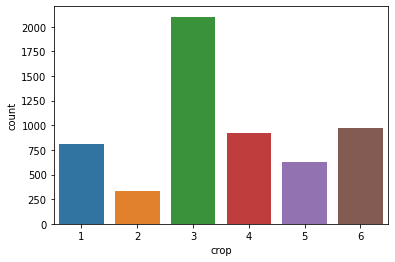

In [ ]:
# 작물별 분포도 확인
sns.countplot(x = annot_info['crop'])

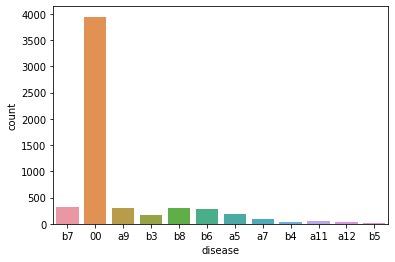

In [ ]:
# 질병 종류별 분포도 확인
sns.countplot(x = annot_info['disease'])
# 확인 결과 정상인 경우가 훨씬 우세함을 확인 할 수 있었다.
# 그렇다면 예측을 할 때에는 당연하게도 정상으로 무조건 예측을 하게 된다면 결과적으로 예측의 정확도는 높은 셈이 될 것이다.
# 그럼 우선 정상인지 아닌지 binary classification을 해주고 정상이 아닌것으로 판별이 된 경우에 대해서만 

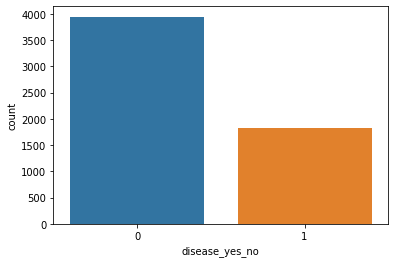

In [ ]:
annot_info['disease_yes_no'] = np.where(annot_info['disease'] == '00', 0 ,1)
sns.countplot(x = annot_info['disease_yes_no'])

In [ ]:
(annot_info['disease_yes_no'] == 0).sum() # 질병에 걸린 작물은 1823개, 정상인 작물은 3944개이다.

3944

In [13]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
            
crop_description = {}
for key, value in crop.items():
  label = f'{key}'
  crop_description[label] = f'{crop[key]}'

disease_description = {}
normal = '00_0'
disease_description[normal] = '정상'
for key, value in disease.items():
  for disease_code in value:
    for risk_code in risk:
      label = f'{disease_code}_{risk_code}'
      disease_description[label] = f'{disease[key][disease_code]}_{risk[risk_code]}'

In [14]:
crops, new_diseases, diseases, risks, labels = [], [], [], [], []
new_disease_labels , crop_labels, disease_labels,risk_labels = [], [],[], []
# 훈련데이터 로드
for i in range(len(TRAIN_JSON_FILES)):
    data = read_json(TRAIN_JSON_FILES[i])
    crop = data['annotations']['crop']
    disease = data['annotations']['disease']
    risk = data['annotations']['risk']
    label=f"{crop}_{disease}_{risk}"
    crop_label = f"{crop}"
    disease_label = f"{disease}_{risk}"
    
    if (str(disease) == '00'):
      new_disease_label = "정상"
    else:
      new_disease_label = f"{new_disease[str(crop)][disease]}_{risk}"
    
    crops.append(crop)
    diseases.append(disease)
    risks.append(risk)


    labels.append(label)
    crop_labels.append(crop_label)
    disease_labels.append(disease_label)
    new_disease_labels.append(new_disease_label)

label_unique = sorted(np.unique(labels))
crop_label_unique = sorted(np.unique(crop_labels))
disease_label_unique = sorted(np.unique(disease_labels))
new_disease_label_unique = sorted(np.unique(new_disease_labels))

label_description = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
crop_description = {key : value for key, value in zip(crop_label_unique, range(len(crop_label_unique)))}
disease_description = {key : value for key, value in zip(disease_label_unique, range(len(disease_label_unique)))}
new_disease_description = {key : value for key, value in zip(new_disease_label_unique, range(len(new_disease_label_unique)))}

In [15]:
train_crop_encoder = {key:idx for idx, key in enumerate(crop_description)}
train_crop_decoder = {val:key for key, val in train_crop_encoder.items()}

train_disease_encoder = {key:idx for idx, key in enumerate(disease_description)}
train_disease_decoder = {val:key for key, val in train_disease_encoder.items()}

train_label_encoder = {key:idx for idx, key in enumerate(label_description)}
train_label_decoder = {val:key for key, val in train_label_encoder.items()}

new_train_disease_encoder = {key:idx for idx, key in enumerate(new_disease_description)}
new_train_disease_decoder = {val:key for key, val in new_train_disease_encoder.items()}

In [ ]:
len(train_crop_encoder), len(train_disease_encoder), len(train_label_encoder), len(new_train_disease_encoder)

(6, 17, 25, 15)

In [16]:
def make_data_df(annot_df, desc_df):
  df = pd.DataFrame()
  ids = sorted(list(annot_df.index))
  annot_cols = ['bbox', 'part', 'crop', 'disease', 'risk']
  desc_cols = ['width', 'height']
  df = pd.concat([annot_df[annot_cols], desc_df[desc_cols]], axis = 1, names = ids)

  return df

data_df = make_data_df(annot_info, desc_info)

In [17]:
x = TRAIN_ID_LIST
y = []
for i, id in enumerate(x):
  idx = TRAIN_IMAGE_NAMES.index(id + '.jpg')
  crop = annot_info['crop'][idx]
  risk = annot_info['risk'][idx]
  disease = annot_info['disease'][idx]
  target = f"{crop}_{disease}_{risk}"
  y.append(target)         

In [19]:
from sklearn.model_selection import StratifiedKFold, KFold
train_folds = []
val_folds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
  train_folds.append(train_idx)
  val_folds.append(val_idx)
  print(f"{len(train_idx)}  {len(val_idx)}")

4613  1154
4613  1154
4614  1153
4614  1153
4614  1153


In [ ]:
#train_file = open("/content/drive/MyDrive/dacon/LGfarm/data/train3.txt", "w")
#val_file =  open("/content/drive/MyDrive/dacon/LGfarm/data/test3.txt", "w")
t_folds = list(map(lambda x: str(x), train_folds))
v_folds = list(map(lambda x: str(x), val_folds))
for i in range(len(t_folds)):
  with open(f"/content/drive/MyDrive/dacon/LGfarm/data/train_pad_fold_new{i+1}.txt", "w") as f:
    for item in train_folds[i]:
      f.write("%d\n" % item)
for i in range(len(v_folds)):
  with open(f"/content/drive/MyDrive/dacon/LGfarm/data/val_pad_fold_new{i+1}.txt", "w") as f:
    for item in val_folds[i]:
      f.write("%d\n" % item)

In [18]:
t,v = [], []
for i in range(cfg['fold']):
  t_, v_ = [], []
  with open(f"/content/drive/MyDrive/dacon/LGfarm/data/train_pad_fold_new{i+1}.txt","r") as file:
    t_.append(file.read().split('\n'))
  with open(f"/content/drive/MyDrive/dacon/LGfarm/data/val_pad_fold_new{i+1}.txt","r") as file:
    v_.append(file.read().split('\n'))
  t.append(t_)
  v.append(v_)

train_id, val_id = [],[]
for i in range(cfg['fold']):
  t[i][0].remove('')
  v[i][0].remove('')
  train_id.append(list(map(lambda x: int(x), t[i][0])))
  val_id.append(list(map(lambda x: int(x), v[i][0])))

In [19]:
def make_rcnn_labels(json_path):
  label = {}
  info = read_json(json_path)['annotations']

  x1 = info['bbox'][0]['x']
  y1 = info['bbox'][0]['y']
  x2 = x1 + info['bbox'][0]['w']
  y2 = y1 + info['bbox'][0]['h']
  bbox = torch.FloatTensor([x1,x2,y1,y2])
  crop, disease, risk = info['crop'], info['disease'], info['risk']
  target = f"{crop}_{disease}_{risk}"
  target = torch.tensor(train_label_encoder[target])
  label['boxes'] = bbox
  label['labels'] = target

  return label




In [20]:
from torchvision.transforms.functional import rotate, pad, resize

def pad2square(pil_img, bg_color = 0):
  width, height = pil_img.size
  if width == height == 512:
    return pil_img
  else:
    result = Image.new(pil_img.mode, (512, 512), bg_color)
    result.paste(pil_img, ((height-width)//2, 0))
    return result

In [21]:
def change_img(img, json_path):
  # 512보다 작거나 같은 이미지는 그대로 적용
  # 512보다 가로 길이가 짧으면 비율 맞춰 줄여서 적용
  img_reshape = {242: 242, 262: 262, 384: 384, 512: 512,622: 420, 682: 384, 740: 354, 1081: 242}
  with open(json_path, 'r') as f:
    json_file = json.load(f)
  width, height = json_file['description']['width'], json_file['description']['height']
  if width > 512:
    img = rotate(img, 90)
  new_w = img_reshape[width]

  new_img = resize(img, (height, new_w))
  new_img = pad2square(new_img)
  return new_img, img

In [22]:
# custom dataset 생성
# 데이터를 dictionary의 형태로 제공하는 것도 가능하다
import albumentations as A
from torchvision import transforms
from PIL import Image

class LGCropDataset(Dataset):
  def __init__(self,ids, labels = None, mode = 'train', types = 'vit'):
    self.mode = mode
    self.types = types
    self.base = '/content/drive/MyDrive/dacon/LGfarm/data/train'
    self.train_img_base = '/content/drive/MyDrive/dacon/LGfarm/data/train/JPG'
    self.test_img_base = '/content/drive/MyDrive/dacon/LGfarm/data/test/JPG'
    self.ids = ids #10000, 100001, 10002.. 이런 형태의 데이터별 id를 저장함
    self.csv_feature_dict = csv_feature_dict
    self.csv_feature_check = [0] * len(self.ids)
    self.csv_features = [None] * len(self.ids)
    self.max_len = cfg['max_len']
    self.label_encoder = train_label_encoder
    self.crop_encoder = train_crop_encoder
    self.disease_encoder = train_disease_encoder
    self.new_disease_encoder = new_train_disease_encoder
    self.data_df = data_df

    self.pretrain_transforms = transforms.Compose(
        [
         transforms.RandomHorizontalFlip(p = 1.0),
         transforms.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.4)
        ]
    )

    self.common_transforms = transforms.Compose(
        [
         transforms.RandomHorizontalFlip(p = 0.5),
         transforms.RandomVerticalFlip(p = 0.5),
         transforms.RandomApply(
             [transforms.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3)],p=0.2
         )
        ]
    )

    self.vit_transform = transforms.Compose([
          transforms.Resize(cfg['vit_img']),
          transforms.ToTensor(),
    ])
    
    self.eff_transform = transforms.Compose([
              transforms.Resize(cfg['eff_img']),
              transforms.ToTensor(),])
    
  def __len__(self):
    return len(self.ids)
  
  def __getitem__(self, idx):
    id = self.ids[idx]
    json_path = f'{self.base}/JSON/{id}.json'
    img_path = f'{self.base}/JPG/{id}.jpg'

    if self.csv_feature_check[idx] == 0:
      csv_path = f'{self.base}/CSV/{id}.csv'
      df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
      df = df.replace('-', 0)

      # MinMax Scaling
      # csv파일에 주어진 속성들의 최대, 최솟값을 사용해서 min max scaling을 진행
      for col in self.csv_feature_dict.keys():
        df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
        df[col] = df[col] / (self.csv_feature_dict[col][1] - self.csv_feature_dict[col][0])
      # zero padding
      pad = np.zeros((self.max_len, len(df.columns)))
      length = min(self.max_len, len(df))
      pad[-length:] = df.to_numpy()[-length:]
      # Transpose to Sequential Data
      csv_feature = pad.T
      self.csv_features[idx] = csv_feature
      self.csv_feature_check[idx] = 1
    else:
      csv_feature = self.csv_features[idx]
    
    img_name = id + '.jpg'
    img = Image.open(os.path.join(self.train_img_base, img_name))


    if self.mode == 'train': # augmentations for training
      if self.types == 'vit': # 전체 모델 train
        img = self.common_transforms(img)
      else: # pretrain model train
        img = self.pretrain_transforms(img)
    img, org_img = change_img(img, json_path) # image padded and resized to (512, 512)

    vit_img = self.vit_transform(img)/255.0
    eff_img = self.eff_transform(img)/255.0
    
    if self.mode == 'train' or self.mode == 'val':
      with open(json_path, 'r') as f:
        json_file = json.load(f)
      
      annotations = json_file['annotations']
      crop, disease, risk = annotations['crop'], annotations['disease'], annotations['risk']
      label = f"{crop}_{disease}_{risk}"
      crop = f"{crop}"
      disease = f"{disease}_{risk}"
      if (str(disease) == '00_0'):
        new_disease_label = "정상"
      else:
        new_disease_label = f"{new_disease[str(crop)][annotations['disease']]}_{risk}"

      return {
          'eff_img' : torch.tensor(eff_img, dtype = torch.float32),
          'csv_feature' : torch.tensor(csv_feature, dtype = torch.float32),
          'label' : torch.tensor(self.label_encoder[label], dtype = torch.long),
          'vit_img' : torch.tensor(vit_img, dtype = torch.float32),
      }
    else:
      return {
          'eff_img' : torch.tensor(eff_img, dtype = torch.float32),
          'csv_feature' : torch.tensor(csv_feature, dtype = torch.float32),
          'vit_img' : torch.tensor(vit_img, dtype = torch.float32),
          'label' : torch.tensor(self.label_encoder[label], dtype = torch.long),
      }

In [23]:
import random
def get_pretrain_loaders(fold):
  train = TRAIN_ID_LIST
  val = [TRAIN_ID_LIST[j] for j in val_id[fold]]
  train_dataset = LGCropDataset(train, types = 'pretrain')
  val_dataset = LGCropDataset(val, mode = 'val', types = 'pretrain')
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 2, shuffle = True)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size =2, shuffle = False)

  return train_dataloader, val_dataloader


def get_loaders(fold):
  #train = [TRAIN_ID_LIST[j] for j in train_folds[fold]]
  #val = [TRAIN_ID_LIST[j] for j in val_folds[fold]]
  train = [TRAIN_ID_LIST[j] for j in train_id[fold]]
  val = [TRAIN_ID_LIST[j] for j in val_id[fold]]
  train_dataset = LGCropDataset(train)
  val_dataset = LGCropDataset(val, mode = 'val')

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = cfg['batch'], shuffle = True)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = cfg['batch'], shuffle = False)

  return train_dataloader, val_dataloader

In [24]:
t_load, v_load = get_loaders(0)
it = 0
for data in iter(t_load):
  it+=1
  if it == 10:break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [25]:
eff = data['eff_img']
vit = data['vit_img']
labels = data['label']

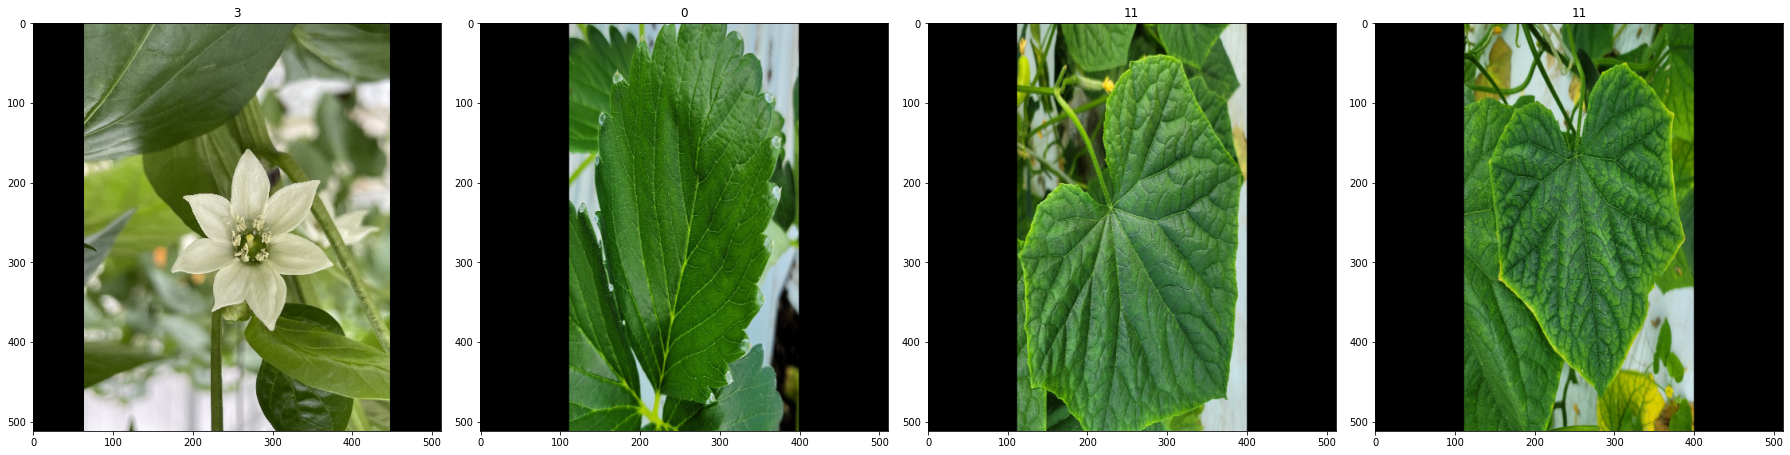

In [26]:
rows, cols = 1,4
axes=[]
fig=plt.figure(figsize = (25,25))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(labels[a-1].numpy())
    axes[-1].set_title(subplot_title)  
    plt.imshow(np.transpose(vit[a-1].numpy(), (1,2,0))*255.0)
fig.tight_layout()    
plt.show()

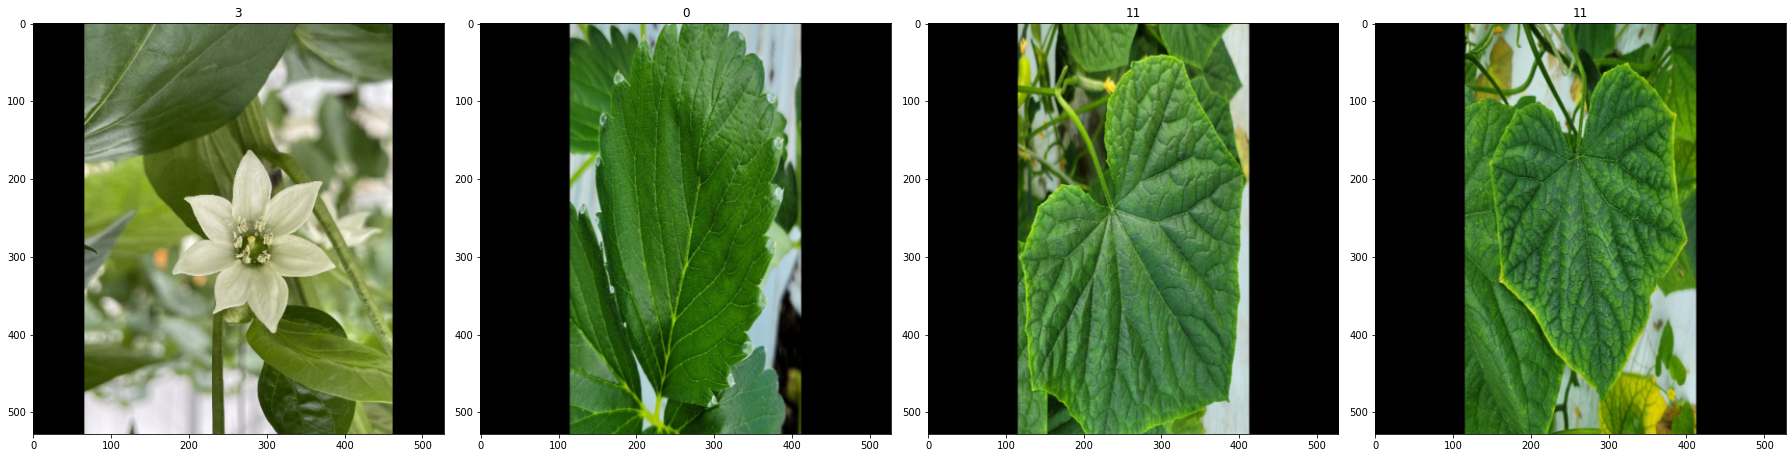

In [27]:
rows, cols = 1,4
axes=[]
fig=plt.figure(figsize = (25,25))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(labels[a-1].numpy())
    axes[-1].set_title(subplot_title)  
    plt.imshow(np.transpose(eff[a-1].numpy(), (1,2,0))*255.0)
fig.tight_layout()    
plt.show()

In [ ]:
mean = torch.zeros(3)
std = torch.zeros(3)
print('==> Computing mean and std..')
for data in tqdm(t_load):
  inputs = data['vit_img']
  for i in range(3):
    mean[i] += inputs[:,i,:,:].mean()
    std[i] += inputs[:,i,:,:].std()

In [24]:
def add_cfg():
  cfg = get_cfg()
  cfg['device'] = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
  cfg['num_feats'] = len(csv_feature_dict)
  cfg['num_class'] = len(train_label_encoder)
  cfg['path_dir'] = '/content/drive/MyDrive/dacon/LGfarm/ckpt'
  cfg['mode'] = 'Mixed'
  if cfg['bbone'] == 'effb5':
    cfg['eff_output'] = 2048
  elif cfg['bbone'] == 'effb6':
    cfg['eff_output'] = 2304
  else:
    cfg['eff_output'] = 1408
  # dataset configurations
  cfg['crop_num'] = len(train_crop_encoder) # 딸기, 토마토, 파프리카, 오이, 고추, 시설포도
  cfg['disease_num'] = len(train_disease_encoder) # a클래스 (36) b클래스(24) 정상(1)
  cfg['new_disease_num'] = len(new_train_disease_encoder)

  cfg['train_mode'] = 'finetune'
  return cfg

cfg = add_cfg()

In [25]:
# 2D image -> sequence of flattened image patches
class PatchEmbed(nn.Module):
  def __init__(self, channel_in, patch_size, emb_size, img_size):
    super().__init__()
    """
    channel_in : 3
    patch_size : 전체 이미지를 조각 낼때 하나의 조각의 한변 길이
    emb_size : 각각의 patch image를 embedding을 했을 떄의 길이
    img_size : 입력할 reshape된 image size (patch의 개수를 위해 필요)
    """
    self.patch_size = patch_size
    """
    # Sol1.
    self.projection = nn.Sequential(
        # break the image in stride1 * stride2 patches and flatten them
        Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Linear(patch_size * patch_size * channel_in, emb_size)
    )
    """
    # Sol2 -> Improvement in performance
    self.projection =  nn.Sequential(
        # using a conv layer instead of a linear layer for performance gain
        nn.Conv2d(channel_in, emb_size, kernel_size = patch_size, stride = patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

    # cls token은 randomly initialized된 torch Parameter이다.
    # class token (= learnable embedding "classification token")
    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))

    # position embedding (None, 1d, 2d, relative)
    self.positions = nn.Parameter(torch.randn((img_size[0] // patch_size) * (img_size[1] // patch_size) + 1, emb_size))
  
  def forward(self, x):
    b, _, _, _ = x.shape
    # batch의 개수만큼 cls token을 추가하는 과정을 반복
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    x = torch.cat([cls_tokens, x], dim = 1)
    # add position embedding
    x += self.positions

    return x

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 1024, num_heads: int = 16, dropout: float = 0.0):
        super().__init__()

        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [27]:
class ResAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn
  
  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res

    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size = 1024, expansion = 4, drop_p = 0.0):
    super().__init__(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size),
    )

In [28]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self, emb_size : int = 1024, 
               drop_p = 0.0,
               forward_expansion = 4, forward_drop_p = 0, **kwargs):
    super().__init__(
        ResAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p)
        )),
        ResAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(
                emb_size, expansion = forward_expansion, drop_p = forward_drop_p),
            nn.Dropout(drop_p)
        ))
    )

class TransformerEncoder(nn.Sequential):
  def __init__(self, depth, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [29]:
class ClassificationHead(nn.Module):
  def __init__(self, emb_size, n_classes):
    super().__init__()
    self.reduce = Reduce('b n e -> b e', reduction = 'mean')
    self.norm = nn.LayerNorm(emb_size)
    # dropout대신에 elu를 사용해봄 (dropout layer은 학습이 되지 않기 때문이다.)
    self.fc = nn.Linear(emb_size, n_classes)
  
  def forward(self, vit_enc, seq, cnn_enc):
    # seq는 환경 데이터를 바탕으로 하는 시계열 바탕의 데이터이다.
    vit_enc = self.reduce(vit_enc)
    out = torch.cat([vit_enc, seq, cnn_enc], dim = 1)
    out = self.norm(out)
    out = self.fc(out)
    return out

class CNNEncoder(nn.Module):
  def __init__(self):
    super(CNNEncoder, self).__init__()
    # 먼저 새로운 이미지로 pretrain을 해서 pretrained weights를 넣어줌
    if cfg['bbone'] == 'effb5':
      self.features = models.efficientnet_b5(pretrained = True).features
    elif cfg['bbone'] == 'effb6':
      self.features = models.efficientnet_b6(pretrained = True)
    else:
      self.features = models.efficientnet_b2(pretrained = True).features
    #torch.load_state_dict(net, torch.load('/content/drive/MyDrive/dacon/LGfarm/ckpt/Eff_b500.bin'))
    self.pool = nn.AdaptiveAvgPool2d(output_size = 1)

  def track_grad(self):
    for module in self.features.modules():
      if isinstance(module, nn.BatchNorm2d):
        module.train()
      else:
        module.eval()


  def forward(self, x):
    """
    x = self.pool(self.features(x))
    x = x.view(x.size(0), -1)
    """
    x = self.features(x)
    return x

class SELayer(nn.Module):
  def __init__(self, channel, reduction = 16):
    super(SELayer, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Sequential(
        nn.Linear(channel, channel // reduction, bias = False),
        nn.ReLU(inplace = True),
        nn.Linear(channel // reduction, channel, bias = False),
        nn.Sigmoid(),
    )
  def forward(self, x):
    b, c, _ = x.size()
    y = self.avg_pool(x).view(b, c)
    y = self.fc(y).view(b, c, 1)
    return x * y.expand_as(x)   

class RNNDecoder(nn.Module):
  def __init__(self, max_len, embedding_dim, num_features):
    super(RNNDecoder, self).__init__()
    self.conv1 = nn.Conv1d(num_features, num_features*2, kernel_size = 3, padding=1, dilation = 1, stride = 1)
    self.conv2 = nn.Conv1d(num_features*2,num_features*4, kernel_size = 3, padding = 1, dilation = 1, stride = 1)
    self.norm = nn.BatchNorm1d(num_features*4)


    self.lstm = nn.LSTM(max_len//2, embedding_dim)
    self.rnn_fc = nn.Linear(num_features * 4 *embedding_dim, embedding_dim)
    

  def forward(self, dec_in):
    conv_out = F.relu(self.conv1(dec_in))
    conv_out = F.relu(self.conv2(conv_out))
    conv_out = F.max_pool1d(conv_out, 2)
    conv_out = self.norm(conv_out)

    hidden, _ = self.lstm(conv_out)
    hidden = hidden.view(hidden.size(0), -1)

    hidden = self.rnn_fc(hidden)
    return hidden

class ViT_Mix(nn.Module):
  def __init__(self, channel_in = 3,
               patch_size = 32,
               emb_size = 1024,
               rnn_emb_size = 512,
               cnn_emb_size = cfg['eff_output'],
               depth = 24,
               max_len = cfg['max_len'],
               **kwargs):
    super().__init__()

    self.cnn_encoder = CNNEncoder() # batch norm제외 나머지 gradient 학습 안되게 함

    self.emb = PatchEmbed(channel_in, patch_size, emb_size, cfg['vit_img'])
    self.enc = TransformerEncoder(depth, emb_size = emb_size, **kwargs)
    self.rnn = RNNDecoder(max_len, rnn_emb_size, num_features = cfg['num_feats'])

    self.final_classifier = ClassificationHead(emb_size + rnn_emb_size + 1000, cfg['num_class'])


  def forward(self, eff_img, vit_img, seq):
    # predicted by EfficientNet_b6
    cnn = self.cnn_encoder(eff_img)
    # predicted by ViT
    enc = self.enc(self.emb(vit_img)) 
    
    # predicted by RNN
    seq = self.rnn(seq)

    final = self.final_classifier(enc, seq, cnn)
    return final

In [30]:
def initialize_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight.data)
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.LayerNorm):
    nn.init.constant_(m.weight.data, 1)
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Conv1d):
    nn.init.kaiming_uniform_(m.weight.data)
    if m.bias is not None:
      nn.init.constant_(m.bias.data, 0)

In [31]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')

    return score


def final_accuracy_function(real, crop, disease):
    real = real.cpu()

    crop = torch.argmax(crop, dim = 1).cpu()

    disease = torch.argmax(disease, dim = 1).cpu()

    score = 0.0
    preds = torch.tensor([0,0])

    for i in range(2):
      crop_id = train_crop_decoder[int(crop[i])]
      disease_id = new_train_disease_decoder[int(disease[i])]

      if disease_id == '정상':
        disease_pred = "00_0"
      else:
        d, risk = disease_id.split('_')[0], disease_id.split('_')[1]
        if str(d) in change_disease[str(crop)]:
          disease_name = change_disease[str(crop_id)][str(d)]
          disease_pred = f"{disease_name}_{risk}"
        else:
          disease_pred = "00_0"



      pred = train_label_encoder[f"{crop_id}_{disease_pred}"]

      preds[i] = pred
    
    score = f1_score(real,preds, average = "macro")
    return score

In [32]:
 # Training Function
def train_one_epoch(model, optim, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    dataset_size = 0
    running_loss = 0.0
    train_acc = 0.0
    running_acc = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, data in pbar:   
        vit_img = data['vit_img'].to(device)
        eff_img = data['eff_img'].to(device)
        csv_feats = data['csv_feature'].to(device)
        label = data['label'].to(device)
            
        batch_size = eff_img.size(0)
        optimizer.zero_grad()

        with amp.autocast(enabled=True):
            pred_final = model(eff_img,vit_img, csv_feats)
            final_loss = criterion(pred_final, label)
    
        scaler.scale(final_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # zero the parameter gradients
        """
        if scheduler is not None:
          scheduler.step(epoch +step / len(dataloader))
        """
    
        
        running_loss += (final_loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
        pbar.set_postfix(
            train_loss=f'{epoch_loss:0.4f}',
                        gpu_memory=f'{mem:0.2f} GB',)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [33]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    epoch_loss = 0.0
    val_scores = 0.0
    running_final_acc = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, data in pbar:   
        eff_img = data['eff_img'].to(device)
        vit_img = data['vit_img'].to(device)
        csv_feats = data['csv_feature'].to(device)
        label = data['label'].to(device)   
        
        batch_size = eff_img.size(0)
        
        #y_pred  = model(img, csv_feats)
        pred_final = model(eff_img, vit_img,csv_feats)

        final_loss    = criterion(pred_final, label)
        final_acc = accuracy_function(label, pred_final)

        running_loss += (final_loss.item() * batch_size)

        dataset_size += batch_size
        running_final_acc += (final_acc.item() * batch_size)
        
        epoch_loss = running_loss / dataset_size
        val_final_scores = running_final_acc / dataset_size
        val_scores = val_final_scores
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        gpu_memory=f'{mem:0.2f} GB',
                         final_acc = f"{val_final_scores : 0.4f}")
    
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [34]:
import time
import copy
from copy import deepcopy
from collections import defaultdict

def run_training(model, optimizer, scheduler,device, num_epochs, fold):
    # To automatically log gradients
    
  
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = model.state_dict()
    best_score  = 0.958
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        torch.cuda.empty_cache()
        """
        if fold > 0:
          if epoch >= 25:
            # Efficient Net의 Batch Layer은 고정하지만 Efficient Net의 나머지 layer은 학습
            # ViT의 Batch Layer은 학습
            fix_second_grad(model)
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
            print(f"FINE TUNING {epoch-25 / 15}")
          elif epoch >= 40:
            # Batch Layer 모두 고정
            fix_third_grad(model)
            optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-5, weight_decay = 1e-5)

        elif fold == 0:
          if epoch >= 10:
            fix_last_grad(model)
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, weight_decay = 1e-5)
            print(f"LAST FINE TUNING FOR FOLD {fold}")
        """

        print(f'Epoch {epoch}/{num_epochs}', end='')

      
        train_loss = train_one_epoch(model, optimizer,scheduler,
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                         device=device, 
                                                         epoch=epoch)
        scheduler.step(val_scores)
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Score'].append(val_scores)
        
        
        print(f'Valid Score: {val_scores:0.4f}')
        
        # deep copy the model
        if val_scores >= best_score:
            print(f"Valid Score Improved ({best_score:0.4f} ---> {val_scores:0.4f})")
            best_score   = val_scores
            best_epoch   = epoch
            best_model_wts = model.state_dict()
            PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_2_v2.bin"
            """
            if fold > 0:
              if epoch >= 40:
                PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_2_v2.bin"
              elif epoch >= 25:
                PATH =   f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_1_v2.bin"
              else:
                PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_v2.bin"
            elif fold == 0:
              PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_v2.bin"
    
            """
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved")
            
      
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_score))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

def get_weight(fold):
  weights = torch.ones(size = (1, cfg['num_class']))
  labels = {}
  for id in train_id[fold]:
    data = read_json(dir = os.path.join('/content/drive/MyDrive/dacon/LGfarm/data/train/JSON', TRAIN_ID_LIST[id] + '.json'))['annotations']
    crop, disease, risk = data['crop'], data['disease'], data['risk']
    label = f"{crop}_{disease}_{risk}"
    if label in labels:
      labels[label] += 1
    else:
      labels[label] = 1
  vals = list(labels.values())
  sums = sum(labels.values())
  for i in range(len(labels)):
    weights[0,i] = 1- (vals[i] / sums)
  return weights

def get_criterion(fold):
  crop_weights = torch.ones(size = (1, cfg['crop_num']))
  crops = {}
  for id in train_id[fold]:
    data = read_json(dir = os.path.join('/content/drive/MyDrive/dacon/LGfarm/data/train/JSON', TRAIN_ID_LIST[id] + '.json'))
    crop = data['annotations']['crop']
    if crop in crops:
      crops[crop] += 1
    else:
      crops[crop] = 0
  values = list(crops.values())
  sums = sum(crops.values())
  for i in range(len(crops)):
    crop_weights[0,i] = 1-(values[i] / sums)
  if cfg['mode'] == 'Mixed':
    crop_criterion = nn.CrossEntropyLoss(weight = crop_weights[0].to(cfg['device']))
    disease_criterion = nn.CrossEntropyLoss(weight = disease_weights[0].to(cfg['device']))
    return crop_criterion, disease_criterion
  else:
    criterion = nn.CrossEntropyLoss(weight = get_weight[0].to(cfg['device']))
    return criterion

In [42]:
weight = get_weight(0)
weight

tensor([[0.7960, 0.8409, 0.8595, 0.9729, 0.8563, 0.9673, 0.9829, 0.9733, 0.9723,
         0.9753, 0.9950, 0.9807, 0.9712, 0.9928, 0.9733, 0.9729, 0.9755, 0.9742,
         0.9980, 0.9963, 0.9976, 0.9881, 0.9931, 0.9967, 0.9978]])

1. 처음에는 pretrained efficient net의 모든 parameter들을 `requires_grad = False`로 설정함으로서 나머지 ViT나 RNN모델들에 대해서 훈련 데이터에 수렴하도록 하였다.
2. 이후에는 미세 조정 및 fine tuning과정을 거침으로서 모델 전체의 batch normalization layer을 제외한 나머지 layer들에 대해서만 학습을 시키도록 하였다.
3. `batch normalizaton layer`에 대해서는 모두 parameter update를 하지 않도록 해야 한다. 따라서 미세 조정을 할 때에는 weight 와 bias의 gradient update를 False로 disable시킨다.  
**다만 중요한 것은 Batch Norm계열들은 running stats를 계산하지 않아야 하므로  `module.eval()`으로 바꿔야 한다는 것이다.**
```
for module in model.modules():
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.eval()
```
4. 즉, fine tuning을 할 때에는 running stats를 계산하지 않도록 하여서 + weight와 bias가 모두 parameter update할 때에 변화하지 않도록 하여야 지금까지 학습한 데이터의 분포가 망가지지 않게 된다.

In [ ]:
#fix_second_grad(model)
model.eval()
for module in model.cnn_encoder.modules():
  if isinstance(module, nn.BatchNorm2d):
    print(module)

In [36]:
## 처음에는 batch normalization을 고정시킴
# 이미 학습이 된 pretrained model에 대해서는 train step에서도 BatchNorm2d가
# running statistic을 계산하지 않도록 한다.
def fix_grad(model):
  for module in model.cnn_encoder.modules():
    if isinstance(module, nn.BatchNorm2d):
      module.bias.requires_grad = True
      module.weight.requires_grad = True
    else:
      for param in module.parameters():
        param.requires_grad = False
  # eval로 해서 fine tuning된 값 사용
  # classifier 부분은 학습을 시켜준다.
  for name, param in model.cnn_encoder.named_parameters():
    n = name.split('.')[0] 
    if (n== 'classifier'):
      param.requires_grad = True

def fix_second_grad(model):
  # cnn encoder의 BatchNorm2d는 고정하고 나머지를 학습 시킨다.
  # vit의 BatchNorm2d는 계속 모두 학습 시킴
  for module in model.modules():
    for param in module.parameters():
      param.requires_grad = True
  for module in model.cnn_encoder.modules():
    if isinstance(module, nn.BatchNorm2d):
      module.weight.requires_grad = False
      module.bias.requires_grad = False
    else:
      for param in module.parameters():
        param.requires_grad = True

# 나머지 모듈들을 학습 시킴 -> Batch Norm제외 나머지 모듈들을 학습 시킴
# Batch Norm의 경우에는 evaluation model로 설정을 해야만 running mean, std로 계산하지 않는다.
# 그러나 running stats를 계산해야 하기 때문에 module을 training mode로 바꾸자
def fix_third_grad(model):
  for module in model.modules():
    if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
      module.weight.requires_grad = False
      module.bias.requires_grad = False
    else:
      for param in module.parameters():
        param.requires_grad = True

# 마지막 fine tuning 순서 -> 마지막 classification layer만 학습을 시킴
def fix_last_grad(model):
  for module in model.modules():
    for param in module.parameters():
      param.requires_grad = False

  for module in model.final_classifier.modules():
    for param in module.parameters():
      param.requires_grad = True
    
def get_params(model):
  params = nn.ParameterList()
  for name, p in model.named_parameters():
    n = name.split('.')[0]
    if n != 'cnn_encoder':
      params.append(p)
    else:
      type_ = name.split('.')[2]
      num = int(name.split('.')[3])
      if type_ == 'classifier':
        params.append(p)
      else:
        if (num >= 7):
          params.append(p)
  return params
# feature 추출 부분은 고정시켜줌

In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()
# 마지막 fine Tuning과정
import warnings
warnings.filterwarnings(action = 'ignore')

for fold in range(1, cfg['fold']):
    print(f'#'*15)
    print(f'### Fold: {fold+1}')
    print(f'#'*15)
    
    train_loader, valid_loader = get_loaders(fold=fold)
    model     = ViT_Mix().to(cfg['device'])
    fix_third_grad(model)
    if os.path.exists(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_1_v2.bin"):
      model.load_state_dict(torch.load(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_1_v2.bin"))
    
    criterion = nn.CrossEntropyLoss(weight = get_weight(fold)[0].to(cfg['device']))

    params = model.parameters()
    # weight decay가 optimizer에서 l2규제를 추가하기 위함이다. -> 과적합을 방지하기 위해서 가중치에 규제항을 추가
    optimizer = torch.optim.AdamW(params,lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'max', patience = 3, factor = 0.33)
    cfg['epoch'] = 10

    model, history = run_training(model, optimizer,scheduler,
                                  device=cfg['device'],
                                   num_epochs=cfg['epoch'], fold=fold)

###############
### Fold: 2
###############
cuda: Tesla P100-PCIE-16GB

Epoch 1/10

Valid : 100%|██████████| 289/289 [01:48<00:00,  2.66it/s, final_acc=0.9560, gpu_memory=7.16 GB, valid_loss=0.1143]


Valid Score: 0.9560
Epoch 2/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.13it/s, final_acc=0.9577, gpu_memory=7.15 GB, valid_loss=0.1284]


Valid Score: 0.9577
Epoch 3/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9612, gpu_memory=7.16 GB, valid_loss=0.1308]


Valid Score: 0.9612
Valid Score Improved (0.9580 ---> 0.9612)
Model Saved
Epoch 4/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9640, gpu_memory=7.38 GB, valid_loss=0.1260]


Valid Score: 0.9640
Valid Score Improved (0.9612 ---> 0.9640)
Model Saved
Epoch 5/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9594, gpu_memory=7.16 GB, valid_loss=0.1503]


Valid Score: 0.9594
Epoch 6/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9585, gpu_memory=7.16 GB, valid_loss=0.1488]


Valid Score: 0.9585
Epoch 7/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.9554, gpu_memory=7.38 GB, valid_loss=0.1642]


Valid Score: 0.9554
Epoch 8/10

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9546, gpu_memory=7.16 GB, valid_loss=0.1601]


Valid Score: 0.9546
Epoch 9/10

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.11it/s, final_acc=0.9585, gpu_memory=7.16 GB, valid_loss=0.1503]


Valid Score: 0.9585
Epoch 10/10

Valid : 100%|██████████| 289/289 [01:35<00:00,  3.03it/s, final_acc=0.9540, gpu_memory=7.16 GB, valid_loss=0.1556]


Valid Score: 0.9540
Training complete in 3h 25m 38s
Best Score: 0.9640
###############
### Fold: 3
###############


KeyboardInterrupt: ignored

#### PRETRAINING + SCRATCH ViT

In [41]:
import gc
gc.collect()
torch.cuda.empty_cache()

import warnings
warnings.filterwarnings(action = 'ignore')

for fold in range(1, cfg['fold']):
    print(f'#'*15)
    print(f'### Fold: {fold+1}')
    print(f'#'*15)
    
    train_loader, valid_loader = get_loaders(fold=fold)
    model     = ViT_Mix().to(cfg['device'])
    fix_third_grad(model)
    if os.path.exists(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_1_v2.bin"):
      model.load_state_dict(torch.load(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_1_v2.bin"))
    
    criterion = nn.CrossEntropyLoss(weight = get_weight(fold)[0].to(cfg['device']))
    #criterion = nn.CrossEntropyLoss()
    #params = get_params(model)

    params = model.parameters()
    # weight decay가 optimizer에서 l2규제를 추가하기 위함이다. -> 과적합을 방지하기 위해서 가중치에 규제항을 추가
    optimizer = torch.optim.AdamW(params,lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'max', patience = 3, factor = 0.33)
    cfg['epoch'] = 10

    model, history = run_training(model, optimizer,scheduler,
                                  device=cfg['device'],
                                   num_epochs=cfg['epoch'], fold=fold)

###############
### Fold: 2
###############
cuda: Tesla P100-PCIE-16GB

Epoch 1/50

Valid : 100%|██████████| 289/289 [01:49<00:00,  2.63it/s, final_acc=0.8198, gpu_memory=6.72 GB, valid_loss=0.3813]


Valid Score: 0.8198
Valid Score Improved (-inf ---> 0.8198)
Model Saved
Epoch 2/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.8941, gpu_memory=6.72 GB, valid_loss=0.1970]


Valid Score: 0.8941
Valid Score Improved (0.8198 ---> 0.8941)
Model Saved
Epoch 3/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9154, gpu_memory=6.71 GB, valid_loss=0.1366]


Valid Score: 0.9154
Valid Score Improved (0.8941 ---> 0.9154)
Model Saved
Epoch 4/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.8898, gpu_memory=6.71 GB, valid_loss=0.1794]


Valid Score: 0.8898
Epoch 5/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.8393, gpu_memory=6.72 GB, valid_loss=0.3392]


Valid Score: 0.8393
Epoch 6/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.9399, gpu_memory=6.72 GB, valid_loss=0.1010]


Valid Score: 0.9399
Valid Score Improved (0.9154 ---> 0.9399)
Model Saved
Epoch 7/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.11it/s, final_acc=0.9269, gpu_memory=6.71 GB, valid_loss=0.1115]


Valid Score: 0.9269
Epoch 8/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9352, gpu_memory=6.93 GB, valid_loss=0.0965]


Valid Score: 0.9352
Epoch 9/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.9182, gpu_memory=6.93 GB, valid_loss=0.1567]


Valid Score: 0.9182
Epoch 10/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.9410, gpu_memory=6.71 GB, valid_loss=0.0970]


Valid Score: 0.9410
Valid Score Improved (0.9399 ---> 0.9410)
Model Saved
Epoch 11/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9395, gpu_memory=6.93 GB, valid_loss=0.1001]


Valid Score: 0.9395
Epoch 12/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9404, gpu_memory=6.93 GB, valid_loss=0.0916]


Valid Score: 0.9404
Epoch 13/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.9415, gpu_memory=6.71 GB, valid_loss=0.0831]


Valid Score: 0.9415
Valid Score Improved (0.9410 ---> 0.9415)
Model Saved
Epoch 14/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9447, gpu_memory=6.93 GB, valid_loss=0.0845]


Valid Score: 0.9447
Valid Score Improved (0.9415 ---> 0.9447)
Model Saved
Epoch 15/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9383, gpu_memory=6.93 GB, valid_loss=0.0982]


Valid Score: 0.9383
Epoch 16/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.13it/s, final_acc=0.9497, gpu_memory=6.71 GB, valid_loss=0.0811]


Valid Score: 0.9497
Valid Score Improved (0.9447 ---> 0.9497)
Model Saved
Epoch 17/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9362, gpu_memory=6.93 GB, valid_loss=0.1041]


Valid Score: 0.9362
Epoch 18/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9417, gpu_memory=6.72 GB, valid_loss=0.0860]


Valid Score: 0.9417
Epoch 19/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9537, gpu_memory=6.72 GB, valid_loss=0.0917]


Valid Score: 0.9537
Valid Score Improved (0.9497 ---> 0.9537)
Model Saved
Epoch 20/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9517, gpu_memory=6.93 GB, valid_loss=0.0780]


Valid Score: 0.9517
Epoch 21/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9549, gpu_memory=6.72 GB, valid_loss=0.0770]


Valid Score: 0.9549
Valid Score Improved (0.9537 ---> 0.9549)
Model Saved
Epoch 22/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9435, gpu_memory=6.93 GB, valid_loss=0.0818]


Valid Score: 0.9435
Epoch 23/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.08it/s, final_acc=0.9509, gpu_memory=6.93 GB, valid_loss=0.0795]


Valid Score: 0.9509
Epoch 24/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.9404, gpu_memory=6.71 GB, valid_loss=0.1002]


Valid Score: 0.9404
FINE TUNING 23.333333333333332
Epoch 25/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.11it/s, final_acc=0.9519, gpu_memory=6.94 GB, valid_loss=0.0794]


Valid Score: 0.9519
FINE TUNING 24.333333333333332
Epoch 26/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.14it/s, final_acc=0.9479, gpu_memory=6.94 GB, valid_loss=0.0756]


Valid Score: 0.9479
FINE TUNING 25.333333333333332
Epoch 27/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.10it/s, final_acc=0.9508, gpu_memory=6.94 GB, valid_loss=0.1022]


Valid Score: 0.9508
FINE TUNING 26.333333333333332
Epoch 28/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.11it/s, final_acc=0.9584, gpu_memory=6.94 GB, valid_loss=0.0782]


Valid Score: 0.9584
Valid Score Improved (0.9549 ---> 0.9584)
Model Saved
FINE TUNING 27.333333333333332
Epoch 29/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.08it/s, final_acc=0.9540, gpu_memory=6.94 GB, valid_loss=0.1079]


Valid Score: 0.9540
FINE TUNING 28.333333333333332
Epoch 30/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.9575, gpu_memory=6.94 GB, valid_loss=0.0955]


Valid Score: 0.9575
FINE TUNING 29.333333333333332
Epoch 31/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.09it/s, final_acc=0.9536, gpu_memory=6.94 GB, valid_loss=0.0980]


Valid Score: 0.9536
FINE TUNING 30.333333333333332
Epoch 32/50

Valid : 100%|██████████| 289/289 [01:33<00:00,  3.10it/s, final_acc=0.9529, gpu_memory=6.95 GB, valid_loss=0.0907]


Valid Score: 0.9529
FINE TUNING 31.333333333333332
Epoch 33/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.13it/s, final_acc=0.9591, gpu_memory=6.94 GB, valid_loss=0.1007]


Valid Score: 0.9591
Valid Score Improved (0.9584 ---> 0.9591)
Model Saved
FINE TUNING 32.333333333333336
Epoch 34/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9495, gpu_memory=6.94 GB, valid_loss=0.1152]


Valid Score: 0.9495
FINE TUNING 33.333333333333336
Epoch 35/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9634, gpu_memory=6.94 GB, valid_loss=0.1251]


Valid Score: 0.9634
Valid Score Improved (0.9591 ---> 0.9634)
Model Saved
FINE TUNING 34.333333333333336
Epoch 36/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9532, gpu_memory=6.94 GB, valid_loss=0.1246]


Valid Score: 0.9532
FINE TUNING 35.333333333333336
Epoch 37/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9553, gpu_memory=6.94 GB, valid_loss=0.1140]


Valid Score: 0.9553
FINE TUNING 36.333333333333336
Epoch 38/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9560, gpu_memory=6.93 GB, valid_loss=0.1217]


Valid Score: 0.9560
FINE TUNING 37.333333333333336
Epoch 39/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.11it/s, final_acc=0.9619, gpu_memory=6.94 GB, valid_loss=0.1217]


Valid Score: 0.9619
FINE TUNING 38.333333333333336
Epoch 40/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9577, gpu_memory=6.94 GB, valid_loss=0.1160]


Valid Score: 0.9577
FINE TUNING 39.333333333333336
Epoch 41/50

Valid : 100%|██████████| 289/289 [01:32<00:00,  3.12it/s, final_acc=0.9588, gpu_memory=6.94 GB, valid_loss=0.1201]


Valid Score: 0.9588
FINE TUNING 40.333333333333336
Epoch 42/50

Train :   4%|▍         | 47/1154 [00:48<18:55,  1.03s/it, gpu_memory=13.43 GB, train_loss=0.0003]


KeyboardInterrupt: ignored

In [42]:
print(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_2_v2.bin")

/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_effb6_16_1_new_finetune_2_v2.bin


In [43]:
PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{cfg['num_head']}_{fold}_new_finetune_2_v2.bin"
torch.save(model.state_dict(), PATH)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

import warnings
warnings.filterwarnings(action = 'ignore')

for fold in range(cfg['fold']):
    print(f'#'*15)
    print(f'### Fold: {fold+1}')
    print(f'#'*15)
    train_loader, valid_loader = get_loaders(fold=fold)
    model     = ViT_Mix().to(cfg['device'])
    
    if os.path.exists(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{fold:02d}.bin"):
      model.load_state_dict(torch.load(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{fold:02d}.bin"))
    """
    #model.apply(initialize_weights)
    criterion1, criterion2 = get_criterion(fold)
    crop_param, disease_param = get_params(model)
    """
    
    criterion = nn.CrossEntropyLoss(weight = get_weight(fold)[0].to(cfg['device']))
    #criterion = nn.NLLLoss(weight = class_weights[0]).to(cfg['device'])
    """
    optimizer1 = torch.optim.Adam(crop_param, lr= 3e-4, weight_decay=0.009) # for crop classification 
    optimizer2 = torch.optim.Adam(disease_param, lr = 3e-4, weight_decay = 0.009) # for disease classification
    """
    params = get_params(model)
    # weight decay가 optimizer에서 l2규제를 추가하기 위함이다. -> 과적합을 방지하기 위해서 가중치에 규제항을 추가
    optimizer = torch.optim.AdamW(params,lr=1e-4, weight_decay=1e-5)
    #scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'max', patience = 3, factor = 0.33)
    #optimizer = torch.optim.AdamW(params, lr = 1e-4, weight_decay = 1e-5)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
    """
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer1)
    scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer2)
    """
    model, history = run_training(model, optimizer,scheduler,
                                  device=cfg['device'],
                                   num_epochs=cfg['epoch'])
  
    

###############
### Fold: 1
###############
cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Valid : 100%|██████████| 577/577 [02:13<00:00,  4.31it/s, final_acc=0.8278, gpu_memory=7.90 GB, valid_loss=0.4620]


Valid Score: 0.8278
Valid Score Improved (-inf ---> 0.8278)
Model Saved
Epoch 2/20

Valid : 100%|██████████| 577/577 [01:53<00:00,  5.09it/s, final_acc=0.8862, gpu_memory=7.90 GB, valid_loss=0.2607]


Valid Score: 0.8862
Valid Score Improved (0.8278 ---> 0.8862)
Model Saved
Epoch 3/20

Valid : 100%|██████████| 577/577 [01:53<00:00,  5.09it/s, final_acc=0.9278, gpu_memory=7.90 GB, valid_loss=0.1532]


Valid Score: 0.9278
Valid Score Improved (0.8862 ---> 0.9278)
Model Saved
Epoch 4/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.05it/s, final_acc=0.9324, gpu_memory=7.90 GB, valid_loss=0.1525]


Valid Score: 0.9324
Valid Score Improved (0.9278 ---> 0.9324)
Model Saved
Epoch 5/20

Valid : 100%|██████████| 577/577 [01:53<00:00,  5.08it/s, final_acc=0.9220, gpu_memory=7.90 GB, valid_loss=0.1642]


Valid Score: 0.9220
Epoch 6/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9353, gpu_memory=7.90 GB, valid_loss=0.1479]


Valid Score: 0.9353
Valid Score Improved (0.9324 ---> 0.9353)
Model Saved
Epoch 7/20

Valid : 100%|██████████| 577/577 [01:53<00:00,  5.09it/s, final_acc=0.9405, gpu_memory=8.01 GB, valid_loss=0.1209]


Valid Score: 0.9405
Valid Score Improved (0.9353 ---> 0.9405)
Model Saved
Epoch 8/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.02it/s, final_acc=0.9353, gpu_memory=8.01 GB, valid_loss=0.1308]


Valid Score: 0.9353
Epoch 9/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9497, gpu_memory=7.90 GB, valid_loss=0.1227]


Valid Score: 0.9497
Valid Score Improved (0.9405 ---> 0.9497)
Model Saved
Epoch 10/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.02it/s, final_acc=0.9428, gpu_memory=7.90 GB, valid_loss=0.1410]


Valid Score: 0.9428
Epoch 11/20

Valid : 100%|██████████| 577/577 [01:55<00:00,  4.99it/s, final_acc=0.9532, gpu_memory=7.90 GB, valid_loss=0.1493]


Valid Score: 0.9532
Valid Score Improved (0.9497 ---> 0.9532)
Model Saved
Epoch 12/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9596, gpu_memory=8.01 GB, valid_loss=0.0835]


Valid Score: 0.9596
Valid Score Improved (0.9532 ---> 0.9596)
Model Saved
Epoch 13/20

Valid : 100%|██████████| 577/577 [01:55<00:00,  5.01it/s, final_acc=0.9382, gpu_memory=8.01 GB, valid_loss=0.1540]


Valid Score: 0.9382
Epoch 14/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9573, gpu_memory=8.01 GB, valid_loss=0.1279]


Valid Score: 0.9573
Epoch 15/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.02it/s, final_acc=0.9457, gpu_memory=7.90 GB, valid_loss=0.1424]


Valid Score: 0.9457
Epoch 16/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9619, gpu_memory=8.01 GB, valid_loss=0.0902]


Valid Score: 0.9619
Valid Score Improved (0.9596 ---> 0.9619)
Model Saved
Epoch 17/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9642, gpu_memory=7.90 GB, valid_loss=0.0973]


Valid Score: 0.9642
Valid Score Improved (0.9619 ---> 0.9642)
Model Saved
Epoch 18/20

Valid : 100%|██████████| 577/577 [01:55<00:00,  5.01it/s, final_acc=0.9700, gpu_memory=7.90 GB, valid_loss=0.1098]


Valid Score: 0.9700
Valid Score Improved (0.9642 ---> 0.9700)
Model Saved
Epoch 19/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.03it/s, final_acc=0.9723, gpu_memory=7.90 GB, valid_loss=0.1262]


Valid Score: 0.9723
Valid Score Improved (0.9700 ---> 0.9723)
Model Saved
Epoch 20/20

Valid : 100%|██████████| 577/577 [01:54<00:00,  5.05it/s, final_acc=0.9642, gpu_memory=7.90 GB, valid_loss=0.1222]


Valid Score: 0.9642
Training complete in 8h 56m 28s
Best Score: 0.9723
###############
### Fold: 2
###############
cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Train :  13%|█▎        | 307/2307 [03:28<22:37,  1.47it/s, gpu_memory=11.49 GB, train_loss=2.8913]


KeyboardInterrupt: ignored

1. 마지막 fclayer에서 log_softmax를 적용하였다면 criterion으로 `NLLLoss`를 사용했어야 할 것이다. 그런데 그렇게 하면 오히려 역전파 과정에서 최적화하는데 속도가 더 늦을 뿐만 아니라 점수의 향상도 너무 더딘 양상을 보였다.

#### pretrain efficient net_b5 and use the features
1. Efficient Net b5 를 efficient net를 사용해서 pretrained 된 weight를 사용하는 바람에 성능이 그렇게 좋은 것 같지 않아서 pretraining과정을 통해서 이미지에서 feature도출하는 부분을 좀더 먼저 학습 시켜 보면 좋지 않을까?
2. image net weight로 이미지를 normalize하였는데, 그 이유는 완전 scratch의 상태부터 학습 시키는 것 보다는 아무래도 pretrained weight를 init한 상태에서부터 학습을 하는 것이 더 편차를 줄이는데 도움이 될 것 같았기 떄문이다.
3. Image Net dataset의 이미지들은 사실상 작물 데이터 셋과 그렇게 큰 유사도를 띄는 데이터셋이 아니기 떄문에 우리는 이 이미지로 pretrain된 가중치 의 일부만 고정하고 나머지는 crop dataset에 맞춰 학습을 시키자

In [ ]:
import torch.nn.functional as F

class Effb5(nn.Module):
  def __init__(self, num_class = len(train_label_encoder)):
    super(Effb5, self).__init__()
    self.features = models.efficientnet_b5(pretrained = True).features
    self.pool = nn.AdaptiveAvgPool2d(output_size = 1)
    self.activate = F.relu
    self.middle = nn.Sequential(
        nn.Dropout(0.2, inplace = True),
        nn.Linear(2048,1536, bias = True),
    )

    self.classifier = nn.Linear(1536, num_class)

  def forward(self, x):
    x = self.pool(self.features(x))
    x = x.view(x.size(0), -1)
    x = self.middle(x)
    x = F.relu(x)
    x = self.classifier(x)
    return x

In [ ]:
net = Effb5()
for name, p in net.named_modules():
  print(name)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

def train_effb5(model, criterion, optimizer, dataloader, epoch, device):
  running_loss = 0.0
  dataset_size = 0
  epoch_loss = 0.0

  model.train()
  scaler = amp.GradScaler()

  pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
  for step, data in pbar:   
    eff_img = data['eff_img'].to(device)
    label = data['label'].to(device)
            
    batch_size = eff_img.size(0)
    optimizer.zero_grad()

    with amp.autocast(enabled=True):
      pred_final = model(eff_img)
      final_loss = criterion(pred_final, label)
    
      scaler.scale(final_loss).backward()
      scaler.step(optimizer)
      scaler.update()
      running_loss += (final_loss.item() * batch_size)
      dataset_size += batch_size
        
      epoch_loss = running_loss / dataset_size
        
      mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
      pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',gpu_memory=f'{mem:0.2f} GB',)

  torch.cuda.empty_cache()
  gc.collect()
    
  return epoch_loss
  
@torch.no_grad()
def valid_effb5(model,criterion, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    epoch_loss = 0.0
    val_scores = 0.0
    running_final_acc = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, data in pbar:   
      eff_img = data['eff_img'].to(device)
      label = data['label'].to(device)   
        
      batch_size = eff_img.size(0)
        
      pred_final = model(eff_img)

      final_loss    = criterion(pred_final, label)
      final_acc = accuracy_function(label, pred_final)

      running_loss += (final_loss.item() * batch_size)

      dataset_size += batch_size
      running_final_acc += (final_acc.item() * batch_size)
        
      epoch_loss = running_loss / dataset_size
      val_final_scores = running_final_acc / dataset_size
      val_scores = val_final_scores
      mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
      pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',gpu_memory=f'{mem:0.2f} GB',final_acc = f"{val_final_scores : 0.4f}")
    
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

import warnings
warnings.filterwarnings(action = 'ignore')
import time
import copy
from copy import deepcopy
from collections import defaultdict

def run_training_effb5(model, optimizer,valid_loader, train_loader, scheduler,device, num_epochs, criterion):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = model.state_dict()
    best_score  = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        torch.cuda.empty_cache()

        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_effb5(model, criterion, optimizer,train_loader,epoch, device)
        
        val_loss, val_scores = valid_effb5(model, criterion, valid_loader, device, epoch)
        scheduler.step(val_scores)
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Score'].append(val_scores)
        
        
        print(f'Valid Score: {val_scores:0.4f}')
        
        # deep copy the model
        if val_scores >= best_score:
            print(f"Valid Score Improved ({best_score:0.4f} ---> {val_scores:0.4f})")
            best_score   = val_scores
            best_epoch   = epoch
            best_model_wts = model.state_dict()
            #PATH = f"best_epoch-{fold:02d}.bin"
            PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/Eff_b5{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved")
            
      
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_score))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

for fold in range(cfg['fold']):
  print(f"Fold : {fold+1}")
  train_loader, valid_loader = get_pretrain_loaders(fold = fold)
  eff_net = Effb5().to(cfg['device'])


  for name, p in eff_net.named_modules():
    if len(name.split('.')) > 1:
      if name.split('.')[0] == 'features':
        num = name.split('.')[1]  
        if int(num) >= 5:
          p.requires_grad = True
        else:
          p.requires_grad = False
    else:
      p.requires_grad = True

  if os.path.exists(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/Eff_b5{fold:02d}.bin"):
    eff_net.load_state_dict(torch.load(f"/content/drive/MyDrive/dacon/LGfarm/ckpt/Eff_b5{fold:02d}.bin"))

  criterion = nn.CrossEntropyLoss(weight = get_weight(fold)[0].to(cfg['device']))
  # 아무리 생각해도 SGD는 그렇게 좋은 optimizer이 아닌 것 같다 -> learning rate를 0.05라는 큰 수로 잡아서 그런지 정규화가 그렇게 잘되는 느낌도 아니었다.
  optimizer = torch.optim.Adam(eff_net.parameters(), lr = 3e-4,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 5)
  model, history = run_training_effb5(eff_net, optimizer, valid_loader, train_loader, scheduler,cfg['device'], cfg['epoch'], criterion)


Fold : 1
cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Valid : 100%|██████████| 577/577 [01:00<00:00,  9.48it/s, final_acc=0.7527, gpu_memory=1.54 GB, valid_loss=0.8559]


Valid Score: 0.7527
Valid Score Improved (-inf ---> 0.7527)
Model Saved
Epoch 2/20

Valid : 100%|██████████| 577/577 [00:45<00:00, 12.74it/s, final_acc=0.8122, gpu_memory=1.54 GB, valid_loss=0.4735]


Valid Score: 0.8122
Valid Score Improved (0.7527 ---> 0.8122)
Model Saved
Epoch 3/20

Valid : 100%|██████████| 577/577 [00:45<00:00, 12.81it/s, final_acc=0.8088, gpu_memory=1.53 GB, valid_loss=0.9051]


Valid Score: 0.8088
Epoch 4/20

Train :  20%|██        | 590/2884 [02:39<10:18,  3.71it/s, gpu_memory=2.64 GB, train_loss=0.3336]


KeyboardInterrupt: ignored

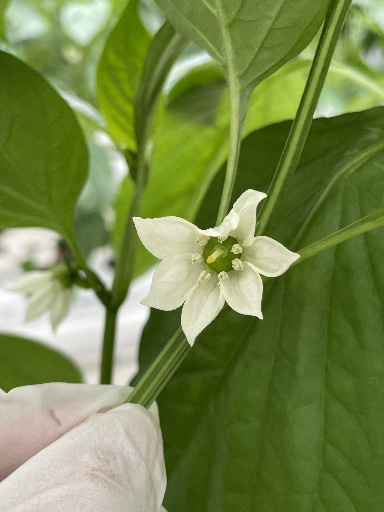

In [ ]:
Image.open('/content/drive/MyDrive/dacon/LGfarm/data/train/JPG/23710.jpg')

In [ ]:
fold = 0
PATH = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad{fold:02d}.bin"
torch.save(model.state_dict(), PATH)

#### EVALUATE

In [ ]:
import zipfile
test_zip = zipfile.ZipFile('/content/drive/MyDrive/dacon/LGfarm/data/test.zip')
test_zip.extractall('/content/drive/MyDrive/dacon/LGfarm/data')

In [81]:
len(TEST_ID_LIST)

51906

In [37]:
def change_test_img(img):
  test_img_reshape = {242: 242, 262: 262, 288 : 288, 301 : 301,312:312, 384: 384, 512: 512,622: 420, 682: 384, 740: 354, 1081: 242}
  width, height = img.size

  if width > 512:
    img = rotate(img, 90)
  new_w = test_img_reshape[width]

  new_img = resize(img, (height, new_w))
  new_img = pad2square(new_img)
  return new_img, img

In [38]:
import natsort
from PIL import Image
TEST_DIR = '/content/drive/MyDrive/dacon/LGfarm/data/test'
#TEST_ID_LIST = natsort.natsorted(os.listdir(TEST_DIR))

class TestDataset(Dataset):
  def __init__(self):
    self.base = TEST_DIR
    self.ids = TEST_ID_LIST
    self.jpgs = list(map(lambda x: os.path.join(TEST_DIR, x,x + '.jpg'),self.ids))
    self.csvs = list(map(lambda x: os.path.join(TEST_DIR, x, x+'.csv'), self.ids))
    self.max_len = cfg['max_len']
    self.csv_features = [None] * len(self.ids)
    self.csv_feature_dict = csv_feature_dict
    self.csv_feature_check = [0] * len(self.ids)
    self.label_encoder = train_label_encoder    

    self.vit_transform = transforms.Compose([
          transforms.Resize(cfg['vit_img']),
          transforms.ToTensor(),
    ])
    
    self.eff_transform = transforms.Compose([
              transforms.Resize(cfg['eff_img']),
              transforms.ToTensor(),])
    
  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    if self.csv_feature_check[idx] == 0:
      csv_path = self.csvs[idx]
      df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
      df = df.replace('-', 0)
      # MinMax scaling
      for col in df.columns:
        df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
        df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
      # zero padding
      pad = np.zeros((self.max_len, len(df.columns)))
      length = min(self.max_len, len(df))
      pad[-length:] = df.to_numpy()[-length:]
      # transpose to sequential data
      csv_feature = pad.T
      self.csv_features[idx] = csv_feature
      self.csv_feature_check[idx] = 1
    else:
      csv_feature = self.csv_features[idx]
    img_path = self.jpgs[idx]
    img = Image.open(img_path)

    img, org_img = change_test_img(img) # image padded and resized to (512, 512)
    
    vit_img = self.vit_transform(img) /255.0
    eff_img = self.eff_transform(img) /255.0

    return {
        'vit_img' : torch.tensor(vit_img, dtype = torch.float32),
        'eff_img' : torch.tensor(eff_img, dtype = torch.float32),
        'csv_feature' : torch.tensor(csv_feature, dtype = torch.float32)
    }



In [39]:
test_dataset = TestDataset()
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False)

In [ ]:
imgs = list(map(lambda x: os.path.join(TEST_DIR, x,x + '.jpg'),TEST_ID_LIST))
for i in imgs:
  try:
    cv2.imread(i)
  except:
    print(i)

In [40]:
def predict(dataset):
  model.eval()

  tqdm_dataset = tqdm(enumerate(dataset))
  results = []
  for batch, batch_item in tqdm_dataset:
    gc.collect()
    torch.cuda.empty_cache()
    eff_img = batch_item['eff_img'].to(cfg['device'])
    vit_img = batch_item['vit_img'].to(cfg['device'])

    seq = batch_item['csv_feature'].to(cfg['device'])
    if (len(seq.size())) == 2:
      seq = torch.unsqueeze(seq,0)
    with torch.no_grad():
      output = model(eff_img, vit_img,seq)
    output = torch.tensor(torch.argmax(output, dim=1), dtype = torch.int32).cpu().numpy()
    results.extend(output)
  return results

In [ ]:
all_results = []
import gc
#for fold in range(cfg['fold']):
for fold in range(1):
  #model_path = f"/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_{cfg['bbone']}_{fold:02d}.bin"
  #model_path = '/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_effb6_16_0_new_finetune.bin'
  model_path = '/content/drive/MyDrive/dacon/LGfarm/ckpt/ViT_Mixed_pad_effb6_16_1_new_finetune_2_v2.bin'
  model = ViT_Mix().to(cfg['device'])
  model.load_state_dict(torch.load(model_path))
  curr_result = predict(test_dataloader)
  all_results.append(curr_result)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
9973it [7:00:25,  2.51s/it]

In [ ]:
final = []
for item in zip(*all_results):
  final.append(item)
final = list(map(lambda x: max(x, key = x.count), final))
preds = np.array([train_label_decoder[int(val)] for val in final])

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon/LGfarm/data/sample_submission.csv')
submission['label'] = preds
submission

In [ ]:
#submission.to_csv(f"/content/drive/MyDrive/dacon/LGfarm/data/submission_vit_{cfg['bbone']}.csv", index = False)
submission.to_csv('/content/drive/MyDrive/dacon/LGfarm/data/submission_final.csv', index = False)